In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from torch.utils.data import TensorDataset, DataLoader
import copy
# from class_models import early_stop

In [2]:
# setting device and reproducibility
has_mps = torch.backends.mps.is_built()
device = "mps" if has_mps else "cuda" if torch.cuda.is_available() else "cpu"
torch.manual_seed(42)
print(f"Using device: {device}")

Using device: cuda


### Learning schedule to find the best learning rate using *ReduceOnPlateau* scheduler
The learning rate scheduler (ReduceLROnPlateau) adjusts the learning rate based on validation loss. The use of ReduceLROnPlateau scheduler helps in adjusting the learning rate dynamically based on the validation loss, which can improve the training process. 

- This training task tracks the best model in the k-fold. 
- The best model is tracked by comparing the validation loss of each epoch. 
- The learning rate (best_lr) that resulted in the lowest validation loss is recorded.

In [3]:
# import data 
data_frame = pd.read_csv("data/NYCTaxiFares.csv", na_values=["NA", "?"])

In [4]:
# function to calculate the distance of the travel
def haversine_distance(dat_f, lat1, lon1, lat2, lon2):
    
    # average radius of the Earth in (km)
    r = 6371
    
    phi1 = np.radians(dat_f[lat1])
    phi2 = np.radians(dat_f[lat2])
    delta_phi = np.radians(dat_f[lat2] - dat_f[lat1])
    delta_lambda = np.radians(dat_f[lon2] - dat_f[lon1])
    
    a = np.sin(delta_phi/2)**2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    d = (r * c)
    
    return d

def preprocessing(df_n, cat_cols):
    """
    Preprocesses the data and adds pandas categorical fields to a dataframe.
    :param df_n: pandas dataframe 
    :param cat_cols: list of categorical fields
    :return: pandas dataframe
    """
    # append a 'dist_km' new feature in the dataframe
    df_n['dist_km'] = haversine_distance(df_n, 'pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude')
    
    # remove outliers
    dfd = df_n[(df_n['fare_amount'] != 49.57) & (df_n['fare_amount'] != 45.00)].copy()
    
    # convert to pd datetime
    dfd['pickup_datetime'] = pd.to_datetime(dfd['pickup_datetime'])
    
    # Correcting pickup_datetime due to daylight savings time (April)
    dfd['EDTdate'] = dfd['pickup_datetime'] - pd.Timedelta(hours=4)
    
    # create new time fields
    dfd['Hour'] = dfd['EDTdate'].dt.hour
    dfd['AMorPM'] = np.where(dfd['Hour']<12, 'am', 'pm')
    dfd['Weekday'] = dfd['EDTdate'].dt.strftime("%a")
    
    # transform to pandas categorical variables
    for cat in cat_cols:
        dfd[cat] = dfd[cat].astype('category')
    
    dfd = dfd.drop(columns=['pickup_datetime'])
    
    return dfd

def model_tensors(df, cat_cols, cont_cols, y_col):
    """
    Get categorical, continuous and label tensors for the model
    :param df: pd dataframe
    :param cat_cols: list of categorical fields
    :param cont_cols: list of continuous fields
    :param y_col: list with the labels
    :return: cats, conts, y tensors
    """
    
    # group the data in categorical continuous and target label    
    cats = np.stack([df[col].cat.codes.values for col in cat_cols], axis=1)
    conts = np.stack([df[col].values for col in cont_cols], axis=1)
    y = df[y_col].values.reshape(-1, 1)

    # Convert to PyTorch tensors
    cats_t = torch.tensor(cats, dtype=torch.int64).to(device)
    conts_t = torch.tensor(conts, dtype=torch.float32).to(device)
    y_t = torch.tensor(y, dtype=torch.float32).to(device)
    
    return cats_t, conts_t, y_t

def create_embedding_sizes(df, cat_cols):
    """
    Create embedding sizes for PyTorch embedding layers
    :param df: pandas dataframe
    :param cat_cols: list of categorical fields
    :return: emb_sizes list
    """
    # categorical sizes list
    cat_sizes = [len(df[col].cat.categories) for col in cat_cols]

    # embedding sizes list (divide the number of unique entries in each column by two, if the result is greater than 50 select 50)
    emb_sizes = [(size, min(50,(size+1)//2)) for size in cat_sizes]
    
    return emb_sizes



In [5]:
df = preprocessing(data_frame, ['Hour', 'AMorPM', 'Weekday'])

cats, conts, y = model_tensors(df, ['Hour', 'AMorPM', 'Weekday'], ['pickup_latitude', 'pickup_longitude', 'dropoff_latitude', 'dropoff_longitude', 'dist_km'], ['fare_amount'])

# number of continuous fields of the conts tensor
n_cont = conts.shape[1]

emb_sizes = create_embedding_sizes(df, ['Hour', 'AMorPM', 'Weekday'])

### Model definition

In [6]:
# Define the model
class TabularModel(nn.Module):
    def __init__(self, emb_sizes, n_cont, out_size, layers, p=0.5):
        super().__init__()
        self.embeds = nn.ModuleList([nn.Embedding(ni, nf) for ni, nf in emb_sizes])
        self.emb_drop = nn.Dropout(p)
        self.batch_norm_cont = nn.BatchNorm1d(n_cont)

        layer_list = []
        n_emb = sum([nf for ni, nf in emb_sizes])
        n_in = n_emb + n_cont
        for i in layers:
            layer_list.append(nn.Linear(n_in, i))
            layer_list.append(nn.ReLU(inplace=True))
            layer_list.append(nn.BatchNorm1d(i))
            layer_list.append(nn.Dropout(p))
            n_in = i

        layer_list.append(nn.Linear(layers[-1], out_size))
        self.layers = nn.Sequential(*layer_list)

    def forward(self, x_cat, x_cont):
        embeddings = [e(x_cat[:, i]) for i, e in enumerate(self.embeds)]
        x = torch.cat(embeddings, 1)
        x = self.emb_drop(x)
        x_cont = self.batch_norm_cont(x_cont)
        x = torch.cat([x, x_cont], 1)
        x = self.layers(x)
        return x

### K-folds function generator
Since the *train_index* and the *val_index* are those who effectively creates the training subsets we can create all the six subsets: 2 for categorical, 2 for continuous and 2 for y labels.

In [7]:
# Function-generator to split the data into k folds
def kfold_split(k, X_cat, X_cont, y):
    kf = KFold(n_splits=k, shuffle=True, random_state=42)
    for train_index, val_index in kf.split(X_cat):
        X_cat_train, X_cat_val = X_cat[train_index], X_cat[val_index]
        X_cont_train, X_cont_val = X_cont[train_index], X_cont[val_index]
        y_train, y_val = y[train_index], y[val_index]
        yield X_cat_train, X_cat_val, X_cont_train, X_cont_val, y_train, y_val

### Model and training parameters

In [8]:
# emb_sizes
# cont r
out_size = 1 # <- for regression task
layers = [200, 100]
p = 0.2 # dropout probability
batch_size = 128
epochs = 30

### Cross-Validation loop

In [9]:
# Cross-validation loop
k = 12
fold = 0
best_lr = None
best_loss = float('inf')

for X_cat_train, X_cat_val, X_cont_train, X_cont_val, y_train, y_val in kfold_split(k, cats, conts, y):
    fold += 1
    print(f"Fold {fold}/{k}")

    # Create datasets and loaders
    train_dataset = TensorDataset(X_cat_train, X_cont_train, y_train)
    val_dataset = TensorDataset(X_cat_val, X_cont_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model, loss, optimizer, and scheduler
    model = TabularModel(emb_sizes, n_cont, out_size, layers, p).to(device)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

    # Training loop
    for epoch in range(epochs):
        model.train()
        train_losses = []

        for X_cat_batch, X_cont_batch, y_batch in train_loader:
            optimizer.zero_grad()
            y_pred = model(X_cat_batch, X_cont_batch)
            loss = torch.sqrt(criterion(y_pred, y_batch))
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())

        model.eval()
        val_losses = []
        with torch.no_grad():
            for X_cat_batch, X_cont_batch, y_batch in val_loader:
                y_pred = model(X_cat_batch, X_cont_batch)
                loss = torch.sqrt(criterion(y_pred, y_batch))
                val_losses.append(loss.item())

        mean_val_loss = np.mean(val_losses)
        scheduler.step(mean_val_loss)

        print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {np.mean(train_losses):.4f}, Val Loss: {mean_val_loss:.4f}")

        # Check for best model
        if mean_val_loss < best_loss:
            best_loss = mean_val_loss
            best_lr = optimizer.param_groups[0]['lr']
            best_model_state = copy.deepcopy(model.state_dict())

print(f"Best Learning Rate: {best_lr}")

Fold 1/12
Epoch 1/30, Train Loss: 4.4167, Val Loss: 2.5578
Epoch 2/30, Train Loss: 2.9123, Val Loss: 2.4919
Epoch 3/30, Train Loss: 2.8007, Val Loss: 2.4535
Epoch 4/30, Train Loss: 2.7708, Val Loss: 2.4906
Epoch 5/30, Train Loss: 2.7318, Val Loss: 2.4034
Epoch 6/30, Train Loss: 2.7152, Val Loss: 2.4150
Epoch 7/30, Train Loss: 2.7029, Val Loss: 2.3889
Epoch 8/30, Train Loss: 2.6847, Val Loss: 2.3813
Epoch 9/30, Train Loss: 2.6825, Val Loss: 2.4087
Epoch 10/30, Train Loss: 2.6683, Val Loss: 2.3981
Epoch 11/30, Train Loss: 2.6681, Val Loss: 2.3733
Epoch 12/30, Train Loss: 2.6545, Val Loss: 2.3718
Epoch 13/30, Train Loss: 2.6392, Val Loss: 2.3938
Epoch 14/30, Train Loss: 2.6374, Val Loss: 2.3715
Epoch 15/30, Train Loss: 2.6265, Val Loss: 2.3778
Epoch 16/30, Train Loss: 2.6328, Val Loss: 2.4113
Epoch 17/30, Train Loss: 2.6138, Val Loss: 2.3432
Epoch 18/30, Train Loss: 2.6177, Val Loss: 2.3539
Epoch 19/30, Train Loss: 2.6210, Val Loss: 2.3399
Epoch 20/30, Train Loss: 2.6018, Val Loss: 2.3444

In [ ]:
# Function to reset weights and biases
def reset_weights(m):
    if hasattr(m, 'reset_parameters'):
        m.reset_parameters()

# Apply the reset function to each layer
model.apply(reset_weights)

### Learning schedule changing the network architecture, the drop-off probability and applying adaptively learning rate

In [ ]:
# emb_sizes
# cont
out_size = 1

# Experiment with different architectures and dropout rates
arch_configs = [
    ([50, 25], 0.1),
    ([50, 25], 0.2),
    ([50, 25], 0.3),
    ([50, 25], 0.4),
    ([100, 50], 0.1),
    ([100, 50], 0.2),
    ([100, 50], 0.3),
    ([100, 50], 0.4),
    ([200, 100], 0.1),
    ([200, 100], 0.2),
    ([200, 100], 0.3),
    ([200, 100], 0.4),
    ([200, 100, 50], 0.1),
    ([200, 100, 50], 0.2),
    ([200, 100, 50], 0.3),
    ([200, 100, 50], 0.4),
]

arch_configs_r = arch_configs[::-1] # <- inverse the architecture configurations list 

batch_size = 128
epochs = 50

# Initialize a list to store results
results = []
k = 4

In [ ]:
for arch, p in arch_configs_r:
    fold = 0
    best_lr = None
    best_loss = float('inf')
    
    print(f"Testing architecture: {arch} with dropout: {p}")

    for X_cat_train, X_cat_val, X_cont_train, X_cont_val, y_train, y_val in kfold_split(k, cats, conts, y):
        fold += 1
        print(f"Fold {fold}/{k}")

        # Create datasets and loaders
        train_dataset = TensorDataset(X_cat_train, X_cont_train, y_train)
        val_dataset = TensorDataset(X_cat_val, X_cont_val, y_val)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 2)
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers = 2)

        # Initialize model, loss, optimizer, and scheduler
        model = TabularModel(emb_sizes, n_cont, out_size, arch, p).to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=0.01)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=10)

        # Training loop
        for epoch in range(epochs):
            model.train()
            train_losses = []

            for X_cat_batch, X_cont_batch, y_batch in train_loader:
                optimizer.zero_grad()
                y_pred = model(X_cat_batch, X_cont_batch)
                loss = torch.sqrt(criterion(y_pred, y_batch))
                loss.backward()
                optimizer.step()
                train_losses.append(loss.item())

            model.eval()
            val_losses = []
            with torch.no_grad():
                for X_cat_batch, X_cont_batch, y_batch in val_loader:
                    y_pred = model(X_cat_batch, X_cont_batch)
                    loss = torch.sqrt(criterion(y_pred, y_batch))
                    val_losses.append(loss.item())

            mean_val_loss = np.mean(val_losses)
            scheduler.step(mean_val_loss)

            print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {np.mean(train_losses):.4f}, Val Loss: {mean_val_loss:.4f}")

            # Check for best model
            if mean_val_loss < best_loss:
                best_loss = mean_val_loss
                best_lr = optimizer.param_groups[0]['lr']
                best_model_state = copy.deepcopy(model.state_dict())

        # Save results for the current fold and configuration
        results.append({
            "Architecture": str(arch),
            "Dropout": p,
            "Fold": fold,
            "Best Learning Rate": best_lr,
            "Best Validation Loss": best_loss
        })

In [10]:
# calculated in Google Colab
results = [{'Architecture': '[200, 100, 50]', 'Dropout': 0.4, 'Fold': 1, 'Best Learning Rate': 0.001, 'Best Validation Loss': 2.4028920413091264}, {'Architecture': '[200, 100, 50]', 'Dropout': 0.4, 'Fold': 2, 'Best Learning Rate': 1e-05, 'Best Validation Loss': 2.3464641108595092}, {'Architecture': '[200, 100, 50]', 'Dropout': 0.4, 'Fold': 3, 'Best Learning Rate': 1e-05, 'Best Validation Loss': 2.3464641108595092}, {'Architecture': '[200, 100, 50]', 'Dropout': 0.4, 'Fold': 4, 'Best Learning Rate': 1e-05, 'Best Validation Loss': 2.3464641108595092}, {'Architecture': '[200, 100, 50]', 'Dropout': 0.3, 'Fold': 1, 'Best Learning Rate': 1e-05, 'Best Validation Loss': 2.382087377124819}, {'Architecture': '[200, 100, 50]', 'Dropout': 0.3, 'Fold': 2, 'Best Learning Rate': 0.0001, 'Best Validation Loss': 2.329015384460318}, {'Architecture': '[200, 100, 50]', 'Dropout': 0.3, 'Fold': 3, 'Best Learning Rate': 0.0001, 'Best Validation Loss': 2.329015384460318}, {'Architecture': '[200, 100, 50]', 'Dropout': 0.3, 'Fold': 4, 'Best Learning Rate': 0.0001, 'Best Validation Loss': 2.329015384460318}, {'Architecture': '[200, 100, 50]', 'Dropout': 0.2, 'Fold': 1, 'Best Learning Rate': 0.0001, 'Best Validation Loss': 2.344660844782303}, {'Architecture': '[200, 100, 50]', 'Dropout': 0.2, 'Fold': 2, 'Best Learning Rate': 0.001, 'Best Validation Loss': 2.3119977666386244}, {'Architecture': '[200, 100, 50]', 'Dropout': 0.2, 'Fold': 3, 'Best Learning Rate': 0.001, 'Best Validation Loss': 2.3119977666386244}, {'Architecture': '[200, 100, 50]', 'Dropout': 0.2, 'Fold': 4, 'Best Learning Rate': 0.001, 'Best Validation Loss': 2.3119977666386244}, {'Architecture': '[200, 100, 50]', 'Dropout': 0.1, 'Fold': 1, 'Best Learning Rate': 0.001, 'Best Validation Loss': 2.353908278818788}, {'Architecture': '[200, 100, 50]', 'Dropout': 0.1, 'Fold': 2, 'Best Learning Rate': 0.001, 'Best Validation Loss': 2.3042694725866975}, {'Architecture': '[200, 100, 50]', 'Dropout': 0.1, 'Fold': 3, 'Best Learning Rate': 0.001, 'Best Validation Loss': 2.3042694725866975}, {'Architecture': '[200, 100, 50]', 'Dropout': 0.1, 'Fold': 4, 'Best Learning Rate': 0.001, 'Best Validation Loss': 2.3042694725866975}, {'Architecture': '[200, 100]', 'Dropout': 0.4, 'Fold': 1, 'Best Learning Rate': 1e-05, 'Best Validation Loss': 2.4053740840533684}, {'Architecture': '[200, 100]', 'Dropout': 0.4, 'Fold': 2, 'Best Learning Rate': 0.0001, 'Best Validation Loss': 2.3605638115570464}, {'Architecture': '[200, 100]', 'Dropout': 0.4, 'Fold': 3, 'Best Learning Rate': 0.0001, 'Best Validation Loss': 2.3605638115570464}, {'Architecture': '[200, 100]', 'Dropout': 0.4, 'Fold': 4, 'Best Learning Rate': 0.0001, 'Best Validation Loss': 2.3605638115570464}, {'Architecture': '[200, 100]', 'Dropout': 0.3, 'Fold': 1, 'Best Learning Rate': 1.0000000000000002e-06, 'Best Validation Loss': 2.3723925624428124}, {'Architecture': '[200, 100]', 'Dropout': 0.3, 'Fold': 2, 'Best Learning Rate': 1e-05, 'Best Validation Loss': 2.319030566462155}, {'Architecture': '[200, 100]', 'Dropout': 0.3, 'Fold': 3, 'Best Learning Rate': 1e-05, 'Best Validation Loss': 2.319030566462155}, {'Architecture': '[200, 100]', 'Dropout': 0.3, 'Fold': 4, 'Best Learning Rate': 1e-05, 'Best Validation Loss': 2.319030566462155}, {'Architecture': '[200, 100]', 'Dropout': 0.2, 'Fold': 1, 'Best Learning Rate': 0.0001, 'Best Validation Loss': 2.355832185724686}, {'Architecture': '[200, 100]', 'Dropout': 0.2, 'Fold': 2, 'Best Learning Rate': 0.001, 'Best Validation Loss': 2.2982420253342597}, {'Architecture': '[200, 100]', 'Dropout': 0.2, 'Fold': 3, 'Best Learning Rate': 0.001, 'Best Validation Loss': 2.2982420253342597}, {'Architecture': '[200, 100]', 'Dropout': 0.2, 'Fold': 4, 'Best Learning Rate': 0.001, 'Best Validation Loss': 2.2982420253342597}, {'Architecture': '[200, 100]', 'Dropout': 0.1, 'Fold': 1, 'Best Learning Rate': 0.0001, 'Best Validation Loss': 2.35029275047368}, {'Architecture': '[200, 100]', 'Dropout': 0.1, 'Fold': 2, 'Best Learning Rate': 0.001, 'Best Validation Loss': 2.3117973336885713}, {'Architecture': '[200, 100]', 'Dropout': 0.1, 'Fold': 3, 'Best Learning Rate': 0.001, 'Best Validation Loss': 2.3117973336885713}, {'Architecture': '[200, 100]', 'Dropout': 0.1, 'Fold': 4, 'Best Learning Rate': 0.001, 'Best Validation Loss': 2.3117973336885713}, {'Architecture': '[100, 50]', 'Dropout': 0.4, 'Fold': 1, 'Best Learning Rate': 0.0001, 'Best Validation Loss': 2.449612270655303}, {'Architecture': '[100, 50]', 'Dropout': 0.4, 'Fold': 2, 'Best Learning Rate': 1e-05, 'Best Validation Loss': 2.3930718297588416}, {'Architecture': '[100, 50]', 'Dropout': 0.4, 'Fold': 3, 'Best Learning Rate': 1e-05, 'Best Validation Loss': 2.3930718297588416}, {'Architecture': '[100, 50]', 'Dropout': 0.4, 'Fold': 4, 'Best Learning Rate': 1e-05, 'Best Validation Loss': 2.3930718297588416}, {'Architecture': '[100, 50]', 'Dropout': 0.3, 'Fold': 1, 'Best Learning Rate': 0.0001, 'Best Validation Loss': 2.411284953869622}, {'Architecture': '[100, 50]', 'Dropout': 0.3, 'Fold': 2, 'Best Learning Rate': 1.0000000000000002e-06, 'Best Validation Loss': 2.355168897016295}, {'Architecture': '[100, 50]', 'Dropout': 0.3, 'Fold': 3, 'Best Learning Rate': 1.0000000000000002e-06, 'Best Validation Loss': 2.355168897016295}, {'Architecture': '[100, 50]', 'Dropout': 0.3, 'Fold': 4, 'Best Learning Rate': 1.0000000000000002e-06, 'Best Validation Loss': 2.355168897016295}, {'Architecture': '[100, 50]', 'Dropout': 0.2, 'Fold': 1, 'Best Learning Rate': 0.001, 'Best Validation Loss': 2.38449447422192}, {'Architecture': '[100, 50]', 'Dropout': 0.2, 'Fold': 2, 'Best Learning Rate': 1e-05, 'Best Validation Loss': 2.330921317482817}, {'Architecture': '[100, 50]', 'Dropout': 0.2, 'Fold': 3, 'Best Learning Rate': 1e-05, 'Best Validation Loss': 2.330921317482817}, {'Architecture': '[100, 50]', 'Dropout': 0.2, 'Fold': 4, 'Best Learning Rate': 1e-05, 'Best Validation Loss': 2.330921317482817}, {'Architecture': '[100, 50]', 'Dropout': 0.1, 'Fold': 1, 'Best Learning Rate': 0.0001, 'Best Validation Loss': 2.377069840143467}, {'Architecture': '[100, 50]', 'Dropout': 0.1, 'Fold': 2, 'Best Learning Rate': 0.01, 'Best Validation Loss': 2.3140968397773545}, {'Architecture': '[100, 50]', 'Dropout': 0.1, 'Fold': 3, 'Best Learning Rate': 0.01, 'Best Validation Loss': 2.3140968397773545}, {'Architecture': '[100, 50]', 'Dropout': 0.1, 'Fold': 4, 'Best Learning Rate': 0.01, 'Best Validation Loss': 2.3140968397773545}, {'Architecture': '[50, 25]', 'Dropout': 0.4, 'Fold': 1, 'Best Learning Rate': 0.0001, 'Best Validation Loss': 2.5049367567588545}, {'Architecture': '[50, 25]', 'Dropout': 0.4, 'Fold': 2, 'Best Learning Rate': 0.0001, 'Best Validation Loss': 2.449887347632441}, {'Architecture': '[50, 25]', 'Dropout': 0.4, 'Fold': 3, 'Best Learning Rate': 0.0001, 'Best Validation Loss': 2.449887347632441}, {'Architecture': '[50, 25]', 'Dropout': 0.4, 'Fold': 4, 'Best Learning Rate': 0.0001, 'Best Validation Loss': 2.449887347632441}, {'Architecture': '[50, 25]', 'Dropout': 0.3, 'Fold': 1, 'Best Learning Rate': 0.0001, 'Best Validation Loss': 2.455257315060188}, {'Architecture': '[50, 25]', 'Dropout': 0.3, 'Fold': 2, 'Best Learning Rate': 0.0001, 'Best Validation Loss': 2.4002857855681716}, {'Architecture': '[50, 25]', 'Dropout': 0.3, 'Fold': 3, 'Best Learning Rate': 0.0001, 'Best Validation Loss': 2.4002857855681716}, {'Architecture': '[50, 25]', 'Dropout': 0.3, 'Fold': 4, 'Best Learning Rate': 0.0001, 'Best Validation Loss': 2.4002857855681716}, {'Architecture': '[50, 25]', 'Dropout': 0.2, 'Fold': 1, 'Best Learning Rate': 0.001, 'Best Validation Loss': 2.4325499724725197}, {'Architecture': '[50, 25]', 'Dropout': 0.2, 'Fold': 2, 'Best Learning Rate': 1e-05, 'Best Validation Loss': 2.369947192483935}, {'Architecture': '[50, 25]', 'Dropout': 0.2, 'Fold': 3, 'Best Learning Rate': 1e-05, 'Best Validation Loss': 2.369947192483935}, {'Architecture': '[50, 25]', 'Dropout': 0.2, 'Fold': 4, 'Best Learning Rate': 1e-05, 'Best Validation Loss': 2.369947192483935}, {'Architecture': '[50, 25]', 'Dropout': 0.1, 'Fold': 1, 'Best Learning Rate': 0.001, 'Best Validation Loss': 2.3988043927940828}, {'Architecture': '[50, 25]', 'Dropout': 0.1, 'Fold': 2, 'Best Learning Rate': 0.001, 'Best Validation Loss': 2.3354567813462226}, {'Architecture': '[50, 25]', 'Dropout': 0.1, 'Fold': 3, 'Best Learning Rate': 0.001, 'Best Validation Loss': 2.3354567813462226}, {'Architecture': '[50, 25]', 'Dropout': 0.1, 'Fold': 4, 'Best Learning Rate': 0.001, 'Best Validation Loss': 2.3354567813462226}]


In [17]:
restults_df = pd.DataFrame(results)
restults_df['Best Validation Loss'].describe()

count    64.000000
mean      2.358939
std       0.047104
min       2.298242
25%       2.319031
50%       2.352101
75%       2.393072
max       2.504937
Name: Best Validation Loss, dtype: float64

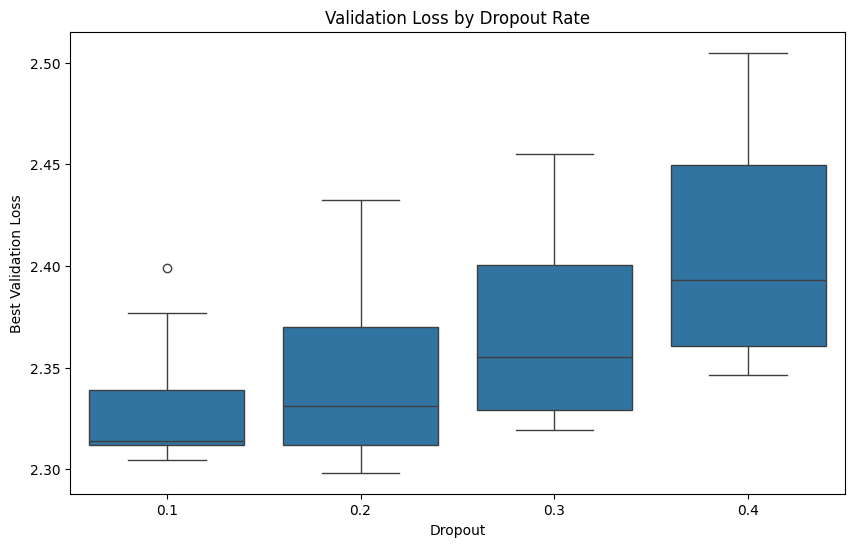

In [18]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.boxplot(x='Dropout', y='Best Validation Loss', data=restults_df)
plt.title('Validation Loss by Dropout Rate')
plt.show()

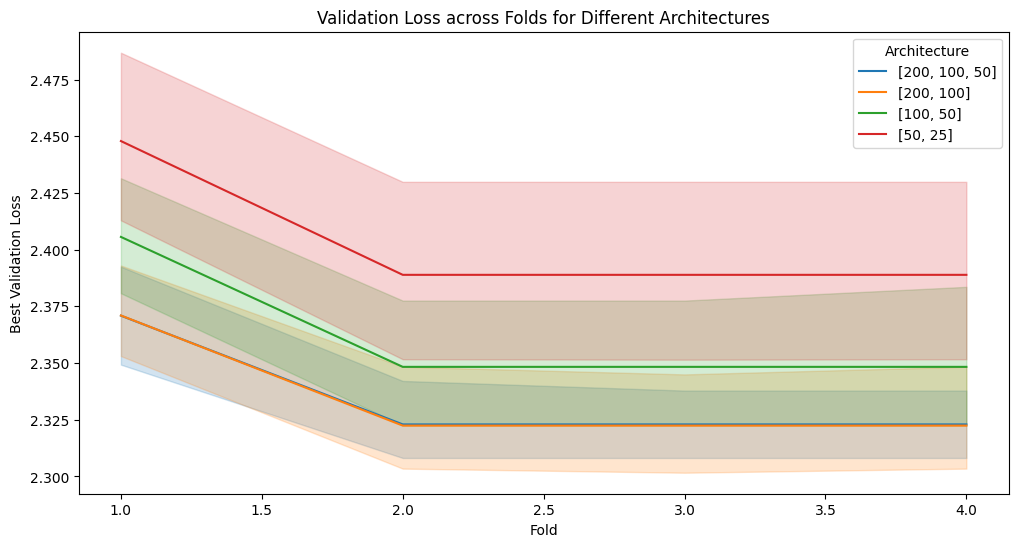

In [19]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='Fold', y='Best Validation Loss', hue='Architecture', data=restults_df)
plt.title('Validation Loss across Folds for Different Architectures')
plt.show()

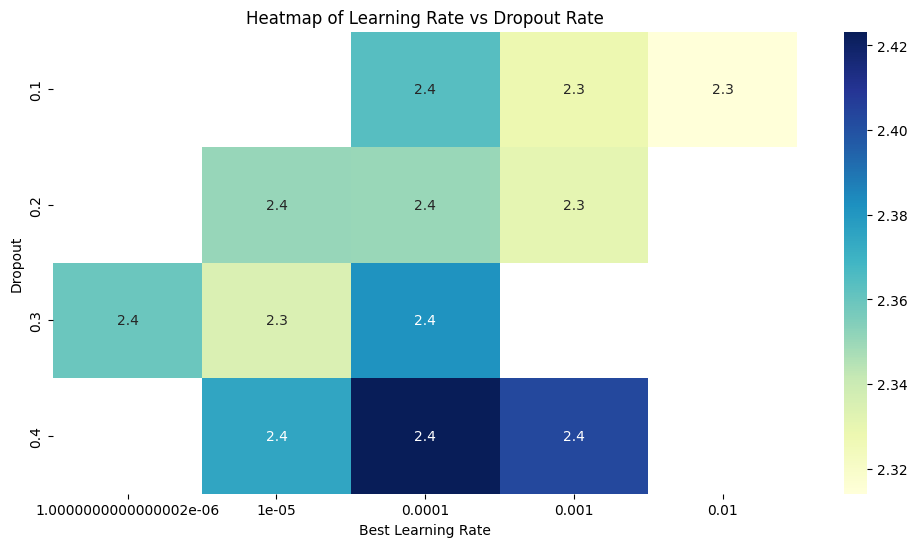

In [20]:
pivot_table = restults_df.pivot_table(values='Best Validation Loss', index='Dropout', columns='Best Learning Rate')
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, annot=True, cmap="YlGnBu")
plt.title('Heatmap of Learning Rate vs Dropout Rate')
plt.show()

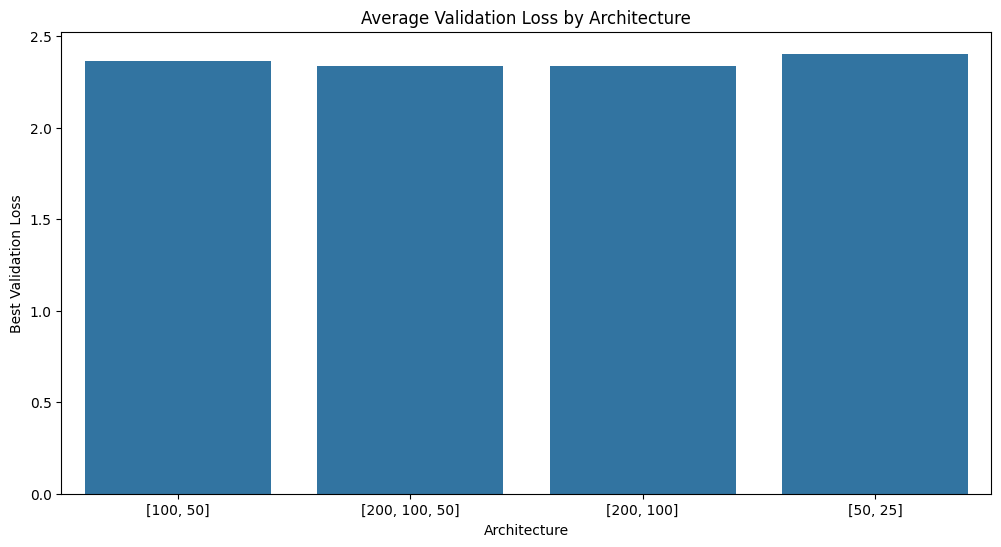

In [22]:
avg_loss = restults_df.groupby('Architecture')['Best Validation Loss'].mean().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='Architecture', y='Best Validation Loss', data=avg_loss)
plt.title('Average Validation Loss by Architecture')
plt.show()

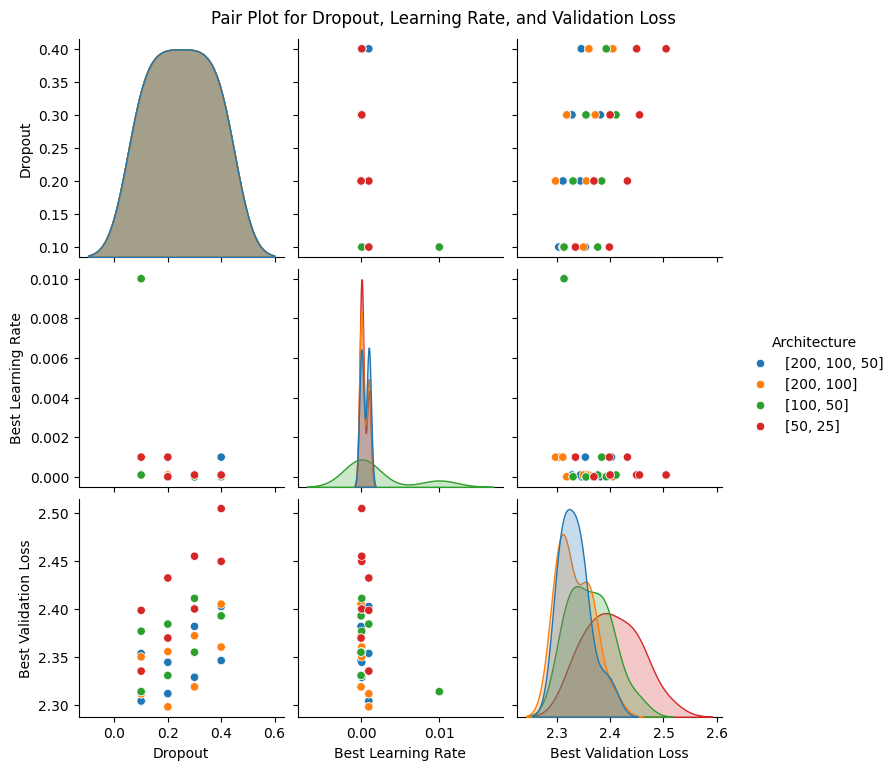

In [24]:
sns.pairplot(restults_df, vars=['Dropout', 'Best Learning Rate', 'Best Validation Loss'], hue='Architecture')
plt.suptitle('Pair Plot for Dropout, Learning Rate, and Validation Loss', y=1.02)
plt.show()